# Practica 3
## Magdaleno Flores Nilton Sebastian

### 1.Preprocesamiento
### 2.Análisis de Datos

#### Importación de librerías y carga de datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

In [2]:
path_ds = 'CTG.csv'
df = pd.read_csv(path_ds)

In [3]:
df.head()

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,12/1/1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,Fmcs_1.txt,5/3/1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,Fmcs_1.txt,5/3/1996,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,5/3/1996,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,5/3/1996,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 40 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FileName  2126 non-null   object 
 1   Date      2126 non-null   object 
 2   SegFile   2126 non-null   object 
 3   b         2126 non-null   float64
 4   e         2126 non-null   float64
 5   LBE       2126 non-null   float64
 6   LB        2126 non-null   float64
 7   AC        2126 non-null   float64
 8   FM        2127 non-null   float64
 9   UC        2127 non-null   float64
 10  ASTV      2127 non-null   float64
 11  MSTV      2127 non-null   float64
 12  ALTV      2127 non-null   float64
 13  MLTV      2127 non-null   float64
 14  DL        2128 non-null   float64
 15  DS        2128 non-null   float64
 16  DP        2128 non-null   float64
 17  DR        2128 non-null   float64
 18  Width     2126 non-null   float64
 19  Min       2126 non-null   float64
 20  Max       2126 non-null   floa

### 1.
#### Eliminación de columnas con más de 20% de nulos
#### Imputación de valores y Detección de valores atípicos y outliers

In [ ]:
def preprocessing(df_input):
    df_proc = df_input.copy()
    
    # 1. Eliminar columnas con más del 20% de valores nulos
    null_pct = df_proc.isnull().mean()                                          # Porcentaje de nulos por columna           
    cols_to_drop = null_pct[null_pct > 0.2].index                               # Umbral del 20%
    if len(cols_to_drop) > 0:
        print(f"Columnas eliminadas (>20% nulos): {list(cols_to_drop)}")
        df_proc = df_proc.drop(columns=cols_to_drop)
    else:
        print("No hay columnas con >20% de nulos para eliminar.")
    
    # 2. Imputar valores faltantes restantes
    numeric_cols = df_proc.select_dtypes(include=[np.number]).columns           ## Columnas numéricas
    categorical_cols = df_proc.select_dtypes(exclude=[np.number]).columns       ## Columnas categóricas
    
    # Imputación Numérica: Mediana
    for col in numeric_cols:
        if df_proc[col].isnull().sum() > 0:
            median_val = df_proc[col].median()
            df_proc[col] = df_proc[col].fillna(median_val)
            
    # Imputación Categórica: Moda
    for col in categorical_cols:
        if df_proc[col].isnull().sum() > 0:
            mode_val = df_proc[col].mode()[0]
            df_proc[col] = df_proc[col].fillna(mode_val)
            
    # 3. Detectar y tratar valores atípicos (Outliers) con IQR
    # Excluimos columnas target o identificadores si es necesario
    # En CTG, 'NSP' y 'CLASS' son targets, no deberíamos clipearlas.
    cols_exclude_outlier = ['NSP', 'CLASS', 'Tendency']
    cols_for_outliers = [c for c in numeric_cols if c not in cols_exclude_outlier]
    
    for col in cols_for_outliers:
        Q1 = df_proc[col].quantile(0.25)
        Q3 = df_proc[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Tratamiento: Clipping (limitar valores al rango)
        # Esto preserva la distribución mejor que eliminar filas
        df_proc[col] = np.clip(df_proc[col], lower_bound, upper_bound)
        
    return df_proc

df_preprocessed = preprocessing(df)

# Verificar que no queden nulos
print(f"\nTotal de nulos después del procesamiento: {df_preprocessed.isnull().sum().sum()}")

No hay columnas con >20% de nulos para eliminar.

Total de nulos después del procesamiento: 0


### 2.
#### Creación de función general y Clasificación

In [6]:
def check_data_completeness_Magdaleno_Flores_Nilton_Sebastian(df):
    """
    Función general para verificar la completitud y calidad de los datos.
    Parámetros:
    df (pd.DataFrame): DataFrame a analizar.
    Retorna:
    pd.DataFrame: DataFrame con el análisis de completitud y calidad de cada columna.
    """
    res = []                                                        # Lista para almacenar resultados
    for col in df.columns:
        dtype = df[col].dtype                                       # Tipo de dato
        total_rows = len(df)                                        # Total de filas
        null_count = df[col].isnull().sum()                         # Conteo de valores nulos
        null_pct = (null_count / total_rows) * 100                  # Porcentaje de nulos
        completeness_pct = 100 - null_pct                           # Porcentaje de completitud        
        unique_vals = df[col].nunique()                             # Valores únicos
        
        # Estadísticos de dispersión y clasificación
        if pd.api.types.is_numeric_dtype(df[col]):
            std_dev = df[col].std()                                 # Desviación estándar
            variance = df[col].var()                                # Varianza
            # Clasificación automática
            if unique_vals > 10:
                col_type = 'Continua'
            else:
                col_type = 'Discreta'
        else:
            std_dev = np.nan                                        # Desviación estándar no aplicable
            variance = np.nan                                       # Varianza no aplicable
            col_type = 'Categórica'
            if unique_vals < 10:
                 col_type = 'Discreta (Cat)'

        res.append({
            'Columna': col,
            'Nulos': null_count,
            '% Completitud': round(completeness_pct, 2),
            'Tipo Dato': dtype,
            'Valores Únicos': unique_vals,
            'Std Dev': round(std_dev, 2) if not pd.isna(std_dev) else np.nan,
            'Varianza': round(variance, 2) if not pd.isna(variance) else np.nan,
            'Clasificación': col_type
        })
    
    return pd.DataFrame(res)

In [7]:
# Ejecutar análisis inicial
analysis_df = check_data_completeness_Magdaleno_Flores_Nilton_Sebastian(df)
analysis_df

,Columna,Nulos,% Completitud,Tipo Dato,Valores Únicos,Std Dev,Varianza,Clasificación
0,FileName,3,99.86,object,352,NaN,NaN,Categórica
1,Date,3,99.86,object,48,NaN,NaN,Categórica
2,SegFile,3,99.86,object,2126,NaN,NaN,Categórica
3,b,3,99.86,float64,979,894.08,799387.54,Continua
4,e,3,99.86,float64,1064,930.92,866610.45,Continua
5,LBE,3,99.86,float64,48,9.84,96.84,Continua
6,LB,3,99.86,float64,48,9.84,96.84,Continua
7,AC,3,99.86,float64,22,3.56,12.68,Continua
8,FM,2,99.91,float64,96,39.03,1523.38,Continua
9,UC,2,99.91,float64,19,2.88,8.28,Continua


### 3.
#### Visualizaciones

##### Histograma

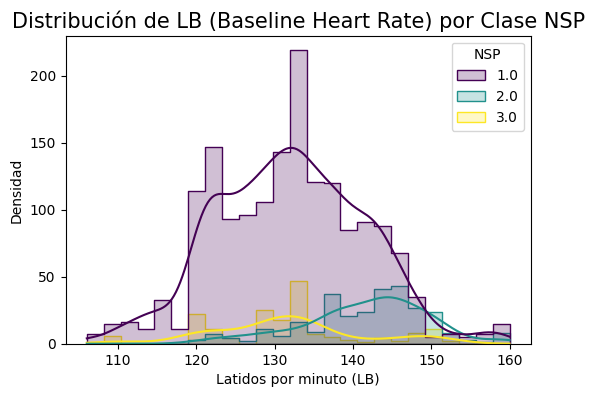

In [15]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df_preprocessed, x='LB', hue='NSP', kde=True, element="step", palette="viridis", common_norm=False)
plt.title('Distribución de LB (Baseline Heart Rate) por Clase NSP', fontsize=15)
plt.xlabel('Latidos por minuto (LB)')
plt.ylabel('Densidad')
plt.show()

##### Boxplots

/tmp/ipykernel_10764/4127688505.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='NSP', y='ASTV', data=df_preprocessed, palette="Set2")


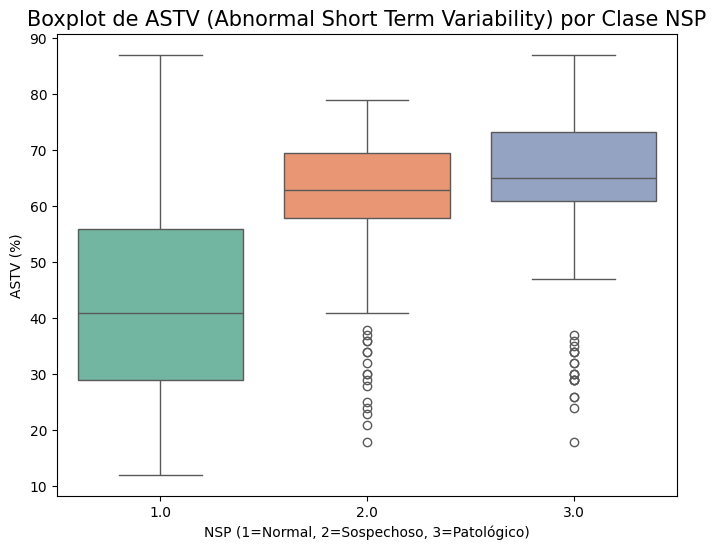

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='NSP', y='ASTV', data=df_preprocessed, palette="Set2")
plt.title('Boxplot de ASTV (Abnormal Short Term Variability) por Clase NSP', fontsize=15)
plt.xlabel('NSP (1=Normal, 2=Sospechoso, 3=Patológico)')
plt.ylabel('ASTV (%)')
plt.show()

##### Barras Horizontales

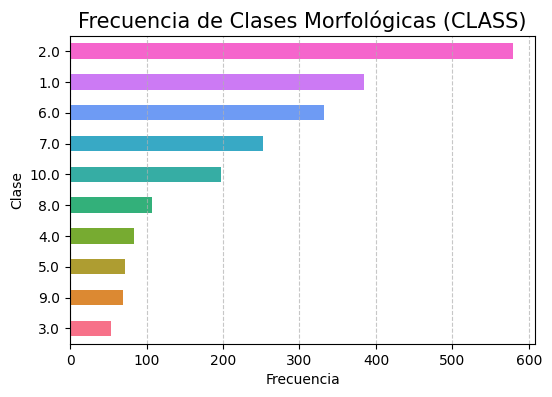

In [17]:
plt.figure(figsize=(6, 4))
class_counts = df_preprocessed['CLASS'].value_counts().sort_values(ascending=True)
class_counts.plot(kind='barh', color=sns.color_palette("husl", len(class_counts)))
plt.title('Frecuencia de Clases Morfológicas (CLASS)', fontsize=15)
plt.xlabel('Frecuencia')
plt.ylabel('Clase')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

##### Líneas - Serie Temporal

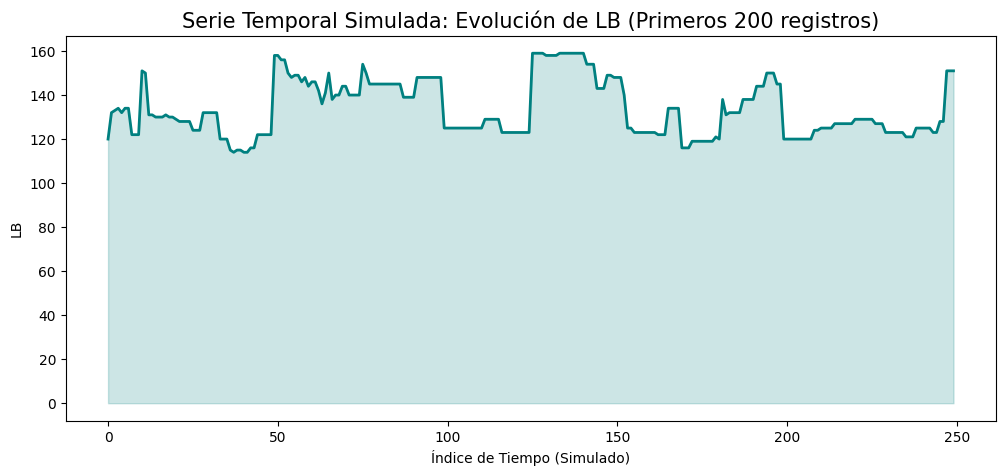

In [19]:
plt.figure(figsize=(12, 5))
subset = df_preprocessed.iloc[:250]
sns.lineplot(data=subset, x=subset.index, y='LB', linewidth=2, color='teal')
plt.title('Serie Temporal Simulada: Evolución de LB (Primeros 200 registros)', fontsize=15)
plt.xlabel('Índice de Tiempo (Simulado)')
plt.ylabel('LB')
plt.fill_between(subset.index, subset['LB'], alpha=0.2, color='teal')
plt.show()

##### Dot Plot

/tmp/ipykernel_10764/2224509828.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=subset_dot, x='AC', y='NSP', orient='h', size=5, palette="deep", alpha=0.6, jitter=True)


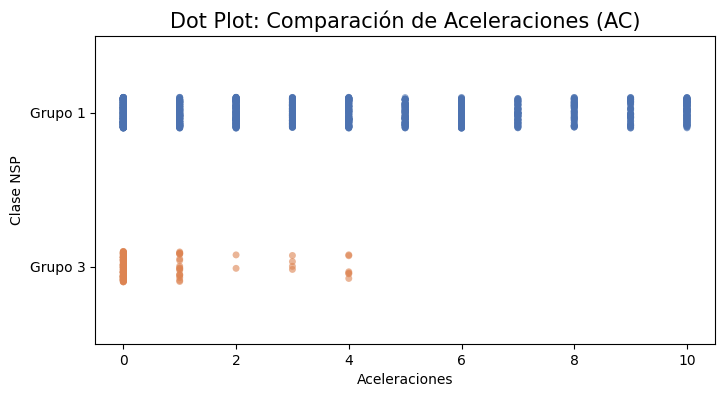

In [24]:
plt.figure(figsize=(8, 4))
subset_dot = df_preprocessed[df_preprocessed['NSP'].isin([1, 3])].copy()
sns.stripplot(data=subset_dot, x='AC', y='NSP', orient='h', size=5, palette="deep", alpha=0.6, jitter=True)
plt.title('Dot Plot: Comparación de Aceleraciones (AC)', fontsize=15)
plt.xlabel('Aceleraciones')
plt.ylabel('Clase NSP')
plt.yticks([0, 1], ['Grupo 1', 'Grupo 3'])
plt.show()